In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
from jax import random
import numpy as np
from jax import random, jit
from jax import jit, vmap, grad, random, lax, ops
import numpy as np
import time

from sgmcmcjax.samplers import build_sgld_sampler

from functools import partial

from jax.config import config
config.update("jax_debug_nans", True)

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define model in JAX
def loglikelihood(theta, x):
    print(f'Theta is {(theta)}')
    print(f'The value is {(-0.5*jnp.dot(x-theta, x-theta))}')
    print(f'shape is {jnp.shape(-0.5*jnp.dot(x-theta, x-theta))}')
    return -0.5*jnp.dot(x-theta, x-theta)

def logprior(theta):
    return -0.5*jnp.dot(theta, theta)*0.01

In [3]:
loglikelihood(1, 2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Theta is 1
The value is -0.5
shape is ()


Array(-0.5, dtype=float32, weak_type=True)

In [4]:
# generate dataset
N, D = 10000, 100
key = random.PRNGKey(0)
X_data = random.normal(key, shape=(N, D))

In [5]:
# build sampler
batch_size = int(0.1*N)
dt = 1e-5
my_sampler = build_sgld_sampler(dt, loglikelihood, logprior, (X_data,), batch_size)

# jit the sampler
#my_sampler = partial(jit, static_argnums=(1,))(my_sampler)

Theta is Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=5/0)>
The value is Traced<ShapedArray(float32[])>with<BatchTrace(level=6/0)> with
  val = Traced<ShapedArray(float32[1000])>with<DynamicJaxprTrace(level=5/0)>
  batch_dim = 0
shape is ()


Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:01<00:00, 8673.31it/s]


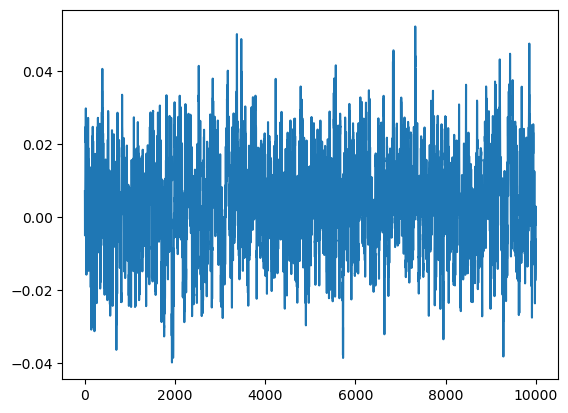

In [6]:
# run sampler
Nsamples = 10000
samples = my_sampler(key, Nsamples, jnp.zeros(D))

idx = 99
plt.plot(samples[:, idx])

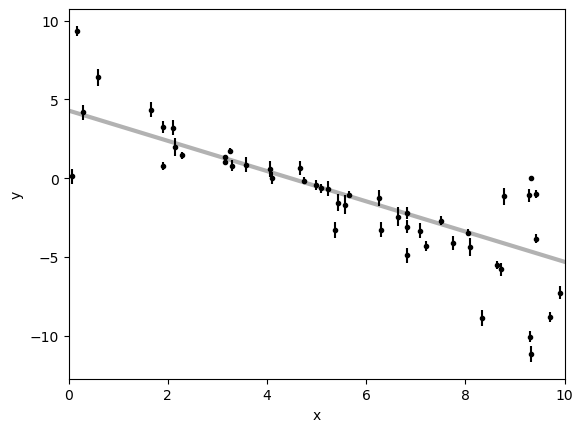

In [7]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [8]:
x = jnp.array([x])
y = jnp.array([y])
yerr = jnp.array([yerr])

In [9]:
def build_grad_log_post(x_data, y_data, yerr, N):
    """
    Builds grad_log_post
    """
    @jit
    def log_prior(theta):
        m, b, log_f = theta
        return jnp.log(m*b*log_f)
    
    @jit
    def log_likelihood(theta, x_val, y_val, y_err):
        m, b, log_f = theta
        model = m * x_val + b
        sigma2 = y_err**2 + model**2 * jnp.exp(2 * log_f)
        output = -0.5 * jnp.sum((y_val - model) ** 2 / sigma2 + jnp.log(sigma2))
        return output

    batch_loglik = jit(vmap(log_likelihood, in_axes=(None, 0, 0,0)))

    def log_post(theta):
        return log_prior(theta) + N*jnp.mean(batch_loglik(theta, x_data, y_data, yerr), axis=0) #one value 

    grad_log_post = jit(grad(log_post))
    return grad_log_post

def build_value_and_grad_log_post(x_data, y_data, yerr, N):
    """
    Builds grad_log_post
    """
    @jit
    def log_prior(theta):
        m, b, log_f = theta
        return jnp.log(m*b*log_f)
    
    @jit
    def log_likelihood(theta, x_val, y_val, y_err):
        m, b, log_f = theta
        model = m * x_val + b
        sigma2 = y_err**2 + model**2 * jnp.exp(2 * log_f)
        output = -0.5 * jnp.sum((y_val - model) ** 2 / sigma2 + jnp.log(sigma2))
        return output

    batch_loglik = jit(vmap(log_likelihood, in_axes=(None, 0, 0,0)))

    def log_post(theta):
        return log_prior(theta) + N*jnp.mean(batch_loglik(theta, x_data, y_data, yerr), axis=0)

    val_and_grad_log_post = jit(value_and_grad(log_post))
    return val_and_grad_log_post

def build_batch_grad_log_post(x_data, y_data, yerr, N):
    """
    Builds grad_log_post that takes in minibatches X and y_data
    """
    @jit
    def log_prior(theta):
        m, b, log_f = theta
        return jnp.log(m*b*log_f)
    
    @jit
    def log_likelihood(theta, x_val, y_val, y_err):
        m, b, log_f = theta
        model = m * x_val + b
        sigma2 = y_err**2 + model**2 * jnp.exp(2 * log_f)
        output = -0.5 * jnp.sum((y_val - model) ** 2 / sigma2 + jnp.log(sigma2))
        return output

    batch_loglik = jit(vmap(log_likelihood, in_axes=(None, 0, 0,0)))

    def log_post(theta, X, y_data):
        return log_prior(theta) + N*jnp.mean(batch_loglik(theta, x_data, y_data, yerr), axis=0)

    grad_log_post = jit(grad(log_post))
    return grad_log_post

In [10]:
def sgld_kernel(key, param, grad_log_post, dt, X, y_data, minibatch_size):
    N, _ = X.shape
    key, subkey1, subkey2 = random.split(key, 3)
    idx_batch = random.choice(subkey1, N, shape=(minibatch_size,))
    paramGrad = grad_log_post(param, X[idx_batch], y_data[idx_batch])
    param = param + dt*paramGrad + jnp.sqrt(2*dt)*random.normal(key=subkey2, shape=(param.shape))
    return key, param


def sgld_sampler_jax_kernel(key, grad_log_post, num_samples, dt, x_0, X, y_data, minibatch_size, print_rate=500):
    dim, = x_0.shape
    samples = np.zeros((num_samples, dim))
    param = x_0
    print(f"Python loop with Jax kernel")
    for i in range(num_samples):
        key, param = sgld_kernel(key, param, grad_log_post, dt, X, y_data, minibatch_size)
        samples[i] = param
        if i%print_rate==0:
            print(f"Iteration {i}/{num_samples}")
    return samples

In [11]:
def ula_kernel(key, param, grad_log_post, dt):
    key, subkey = random.split(key)
    paramGrad = grad_log_post(param)
    param = param + dt*paramGrad + jnp.sqrt(2*dt)*random.normal(key=subkey, shape=(param.shape))
    return key, param


def ula_sampler_jax_kernel(key, grad_log_post, num_samples, dt, x_0, print_rate=500):
    dim, = x_0.shape
    samples = np.zeros((num_samples, dim))
    param = x_0
    print(f"Python loop with Jax kernel")
    for i in range(num_samples):
        key, param = ula_kernel(key, param, grad_log_post, dt)
        samples[i] = param
        if i%print_rate==0:
            print(f"Iteration {i}/{num_samples}")
    return samples

In [12]:

N = 1000
#dt = 5e-3
dt = 5e-3
num_samples = 100
print_rate = num_samples/2
initial_theta = jnp.array([0.1, 4.0, 0.1])

grad_log_post = build_grad_log_post(x, y, yerr, N)
ula_sampler_jax_kernel(key, grad_log_post, num_samples, dt=dt, x_0=initial_theta, print_rate=print_rate)

Python loop with Jax kernel
Iteration 0/100
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/pjit.py", line 1252, in _pjit_call_impl
    return compiled.unsafe_call(*args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/profiler.py", line 314, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1920, in __call__
    dispatch.check_special(self.name, arrays)
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/dispatch.py", line 436, in check_special
    _check_special(name, buf.dtype, buf)
  File "/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/dispatch.py", line 441, in _check_special
    raise FloatingPointError(f"invalid v